In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid, cifar_noniid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img


import math


# from sympy import * 
from utils.functions import *

%load_ext autoreload
%autoreload 2

In [2]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 40  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=1 #"the number of local epochs: E"
    local_bs=100 #"local batch size: B"
    bs=100 #"test batch size"
    lr=0.03 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'SGD' #'ADAM'
    loss = 'Cross'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=0
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

True
cuda


In [3]:
# load dataset and split users

from torchvision import datasets, transforms

trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users

dict_users = mnist_noniid(dataset_train, args.num_users)

img_size = dataset_train[0][0].shape

c:\programdata\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [4]:
print(dict_users[0][0])

print(dataset_train.train_labels[dict_users[0][0]],dataset_train.train_labels[dict_users[0][797]],dataset_train.train_labels[dict_users[0][1499]])

18397
tensor(3) tensor(4) tensor(4)


In [5]:
from models.Nets import *
from utils.functions import *

net_glob = CNNMnist3(args)
net_glob = net_glob.cuda()

net_glob.train()
# copy weights
w_glob = net_glob.state_dict()

d = tensor_dim(w_glob)

print(d)

62346


In [6]:
p = 0
N = 40
K = 8

args.local_ep=1

N_trials = 1
Max_iter = 100

lr_array = [0.03]


starting_iter_array = [199, 399, 599, 799]

recon_array_proposed = []
recon_array_random = []

gain_array = []

for ii in range(len(starting_iter_array)):
    starting_iter = starting_iter_array[ii]



    net_glob = CNNMnist2(args)
    net_glob = net_glob.cuda()

    PATH = "./save_models/MNIST_NonIID_CNN_N40_K8_net_glob_iter"+str(starting_iter)
    net_glob.load_state_dict(torch.load(PATH))
    net_glob.eval()

    acc_test, loss_test = test_img(net_glob, dataset_test, args)


    acc_test_arr_v2  = np.zeros((len(lr_array), N_trials, Max_iter))
    loss_test_arr_v2 = np.zeros((len(lr_array), N_trials, Max_iter))



    P_random = []


    for trial_idx in range(N_trials):


        for lr_idx in range(len(lr_array)):

            print()
            print('Learning Rate =',args.lr)
            print()
    #         net_glob = CNNMnist2(args)
    #         net_glob = net_glob.cuda()
    #         print(net_glob)

            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

    #         w_glob_array = []
    #         w_locals_array = []

            w_locals_array_np_v2 = np.zeros((Max_iter,N,d))
            w_glob_array_np_v2 = np.zeros((Max_iter,d))

            w_glob_array = []

            for iter in range(Max_iter): #args.epochs

                args.lr = lr_array[lr_idx]/(starting_iter)
    #             if iter >= 200:
    #                 args.lr = lr_array[lr_idx] * 0.1
    #             elif iter >= 300:
    #                 args.lr = lr_array[lr_idx] * 0.01

                w_locals, loss_locals = [], []
                w_locals_all = []

    # #             u = np.random.binomial(1, 1-p, size=(N))
    #             u = np.ones((N,))
    #             for u_idx in range(N):
    #                 p_sel = p_per_user[u_idx]
    #                 u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

    #             result = np.where(u == 1)

                ###############################
                # 1. Random Selection
                ###############################
                idxs_users = np.random.choice(N, K, replace=False)

                p_tmp = np.zeros(N)
                p_tmp[idxs_users] = 1

                P_random.append(p_tmp)

    #             print('Learning Rate =',args.lr)
            #     idxs_users = np.random.choice(range(N), K, replace=False)
                for idx in range(N):
            #         print(idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))

                    w_locals_all.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    if idx in idxs_users:
                        w_locals.append(copy.deepcopy(w))

                    stt_pos = 0
                    for k in w.keys():
                        tmp1 = w[k].cpu().detach().numpy()
                        cur_shape = tmp1.shape
                        _d = np.prod(cur_shape)

                        end_pos = stt_pos + _d

    #                     w_glob_array_np[iter,stt_pos:end_pos] = np.reshape(tmp1,(_d,))        


                        w_locals_array_np_v2[iter,idx,stt_pos:end_pos] = np.reshape(tmp1,(_d,))

                        stt_pos = end_pos




                # update global weights
                w_glob = FedAvg(w_locals)


                stt_pos = 0
                for k in w_glob.keys():
                    tmp2 = w_glob[k].cpu().detach().numpy()
                    cur_shape = tmp2.shape
                    _d = np.prod(cur_shape)

                    end_pos = stt_pos + _d

    #                 print(_d, stt_pose, end_pos)

                    w_glob_array_np_v2[iter,stt_pos:end_pos] = np.reshape(tmp2,(_d,))

                    stt_pos = end_pos


    #             w_locals_array.append(w_locals_all)
                w_glob_array.append(w_glob)

                ModelDiff_tensor(net_glob.state_dict(), w_glob_array[iter])     

                # copy weight to net_glob
                if iter < 1000:
                    print('net_glob is updated !!')
                    net_glob.load_state_dict(w_glob)
    #             else:
    #                 net_glob.load_state_dict(w_glob_prev)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v2[lr_idx][trial_idx][iter]  = acc_test
                loss_test_arr_v2[lr_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
                #print(loss_train)

#                 if iter % 100 == 99:
#                     PATH = "./save_models/MNIST_NonIID_CNN_N40_K8_net_glob_iter"+str(1400+iter)
#                     torch.save(net_glob.state_dict(), PATH)
                    
    grad_locals_array_np_v2 = np.zeros((100,N,d))
    grad_glob_array_np_v2 = np.zeros((100,d))

    for i in range(1, 99):
    #     print(i)
        grad_locals_array_np_v2[i+1,:,:] = (w_locals_array_np_v2[i,:,:] - w_glob_array_np_v2[i-1,:])*1400

        grad_glob_array_np_v2[i-1,:] = (w_glob_array_np_v2[i,:] - w_glob_array_np_v2[i-1,:])*1400

        ModelDiff_np(grad_locals_array_np_v2[i+1,0,:], grad_glob_array_np_v2[i-1,:])
        
    P_random = np.array(P_random)

    print(np.shape(P_random))

    print(np.sum(P_random, axis=0))
    
    # Pseudo Inversion

    offset = 1
    P_random_tmp = P_random[40+offset:90+offset,:]

    PT = P_random_tmp.transpose()

    print(np.shape(PT))

    PTP = np.matmul(P_random_tmp.transpose(), P_random_tmp)

    print(np.linalg.matrix_rank(PTP))

    PTP_inv=np.linalg.pinv(PTP)


    # print(np.shape(PT), np.shape(w_glob_array_np[10:60,:]))
    Pw_glob = np.matmul(PT, grad_glob_array_np_v2[40:90,:])
    grad_recon_np = K * np.matmul(PTP_inv, Pw_glob)

    # ModelDiff_np(w_locals_array_np[-1,1,:], w_recon_np[1])
    l2_diff = np.zeros((N))
    l2_diff_ = np.zeros((N))
    for i in range(N):
        if i == N-1:
            l2_diff_[i] = ModelDiff_np(grad_locals_array_np_v2[40,i,:], (grad_recon_np[i-1]+grad_recon_np[i])/2)
        else:
            l2_diff_[i] = ModelDiff_np(grad_locals_array_np_v2[40,i,:], (grad_recon_np[i]+grad_recon_np[i+1])/2)
    print()
    print()
    for i in range(N):
        l2_diff[i] = ModelDiff_np(grad_locals_array_np_v2[50,i,:], (grad_recon_np[i]))
        
    gain = np.sum(l2_diff_)/np.sum(l2_diff)

    print(np.sum(l2_diff_)/N)
    print(np.sum(l2_diff)/N)

    print(np.sum(l2_diff_)/np.sum(l2_diff))
    
    recon_array_proposed.append(l2_diff_)
    
    recon_array_random.append(l2_diff)
    
    gain_array.append(gain)


Test set: Average loss: 0.3243 
Accuracy: 8773/10000 (87.73%)


Learning Rate = 0.03

[[45.09035491]] [[45.09110784]] [[7.45988775e-06]]
net_glob is updated !!

Test set: Average loss: 0.3231 
Accuracy: 8778/10000 (87.78%)

Round   0, Train average loss 0.334 Test accuracy 87.780
[[45.09110784]] [[45.09169235]] [[6.09502215e-06]]
net_glob is updated !!

Test set: Average loss: 0.3222 
Accuracy: 8779/10000 (87.79%)

Round   1, Train average loss 0.333 Test accuracy 87.790
[[45.09169235]] [[45.09271597]] [[6.7700812e-06]]
net_glob is updated !!

Test set: Average loss: 0.3210 
Accuracy: 8780/10000 (87.80%)

Round   2, Train average loss 0.332 Test accuracy 87.800
[[45.09271597]] [[45.09363479]] [[1.13266961e-05]]
net_glob is updated !!

Test set: Average loss: 0.3200 
Accuracy: 8784/10000 (87.84%)

Round   3, Train average loss 0.331 Test accuracy 87.840
[[45.09363479]] [[45.09427869]] [[1.81836677e-06]]
net_glob is updated !!

Test set: Average loss: 0.3199 
Accuracy: 8785/10000 (87.85

[[45.12131624]] [[45.12191299]] [[2.76885027e-06]]
net_glob is updated !!

Test set: Average loss: 0.3110 
Accuracy: 8800/10000 (88.00%)

Round  42, Train average loss 0.322 Test accuracy 88.000
[[45.12191299]] [[45.1225356]] [[1.7641923e-06]]
net_glob is updated !!

Test set: Average loss: 0.3109 
Accuracy: 8802/10000 (88.02%)

Round  43, Train average loss 0.322 Test accuracy 88.020
[[45.1225356]] [[45.12314256]] [[1.78639095e-06]]
net_glob is updated !!

Test set: Average loss: 0.3109 
Accuracy: 8804/10000 (88.04%)

Round  44, Train average loss 0.322 Test accuracy 88.040
[[45.12314256]] [[45.12386051]] [[6.10796902e-06]]
net_glob is updated !!

Test set: Average loss: 0.3109 
Accuracy: 8806/10000 (88.06%)

Round  45, Train average loss 0.322 Test accuracy 88.060
[[45.12386051]] [[45.1243911]] [[7.93524311e-07]]
net_glob is updated !!

Test set: Average loss: 0.3109 
Accuracy: 8808/10000 (88.08%)

Round  46, Train average loss 0.322 Test accuracy 88.080
[[45.1243911]] [[45.1248363]]


Test set: Average loss: 0.3089 
Accuracy: 8805/10000 (88.05%)

Round  84, Train average loss 0.320 Test accuracy 88.050
[[45.14667216]] [[45.14737413]] [[1.79875675e-06]]
net_glob is updated !!

Test set: Average loss: 0.3089 
Accuracy: 8805/10000 (88.05%)

Round  85, Train average loss 0.320 Test accuracy 88.050
[[45.14737413]] [[45.14803688]] [[1.7906218e-06]]
net_glob is updated !!

Test set: Average loss: 0.3090 
Accuracy: 8806/10000 (88.06%)

Round  86, Train average loss 0.320 Test accuracy 88.060
[[45.14803688]] [[45.14860971]] [[2.7037977e-06]]
net_glob is updated !!

Test set: Average loss: 0.3090 
Accuracy: 8805/10000 (88.05%)

Round  87, Train average loss 0.320 Test accuracy 88.050
[[45.14860971]] [[45.14921592]] [[1.26442054e-06]]
net_glob is updated !!

Test set: Average loss: 0.3090 
Accuracy: 8807/10000 (88.07%)

Round  88, Train average loss 0.320 Test accuracy 88.070
[[45.14921592]] [[45.15007039]] [[2.61342893e-06]]
net_glob is updated !!

Test set: Average loss: 0.


Test set: Average loss: 0.2927 
Accuracy: 8841/10000 (88.41%)


Learning Rate = 0.0001507537688442211

[[45.48138806]] [[45.48157731]] [[5.56252472e-07]]
net_glob is updated !!

Test set: Average loss: 0.2925 
Accuracy: 8841/10000 (88.41%)

Round   0, Train average loss 0.302 Test accuracy 88.410
[[45.48157731]] [[45.48184891]] [[9.80735562e-07]]
net_glob is updated !!

Test set: Average loss: 0.2921 
Accuracy: 8843/10000 (88.43%)

Round   1, Train average loss 0.302 Test accuracy 88.430
[[45.48184891]] [[45.4820536]] [[6.37124916e-07]]
net_glob is updated !!

Test set: Average loss: 0.2918 
Accuracy: 8844/10000 (88.44%)

Round   2, Train average loss 0.302 Test accuracy 88.440
[[45.4820536]] [[45.48224545]] [[5.78491025e-07]]
net_glob is updated !!

Test set: Average loss: 0.2916 
Accuracy: 8844/10000 (88.44%)

Round   3, Train average loss 0.301 Test accuracy 88.440
[[45.48224545]] [[45.48242691]] [[5.63486257e-07]]
net_glob is updated !!

Test set: Average loss: 0.2913 
Accuracy: 8

[[45.49097241]] [[45.49119247]] [[6.95548268e-07]]
net_glob is updated !!

Test set: Average loss: 0.2854 
Accuracy: 8866/10000 (88.66%)

Round  42, Train average loss 0.296 Test accuracy 88.660
[[45.49119247]] [[45.49139769]] [[1.16353926e-07]]
net_glob is updated !!

Test set: Average loss: 0.2854 
Accuracy: 8866/10000 (88.66%)

Round  43, Train average loss 0.295 Test accuracy 88.660
[[45.49139769]] [[45.49163626]] [[5.45916096e-07]]
net_glob is updated !!

Test set: Average loss: 0.2854 
Accuracy: 8866/10000 (88.66%)

Round  44, Train average loss 0.295 Test accuracy 88.660
[[45.49163626]] [[45.49182292]] [[2.44483517e-07]]
net_glob is updated !!

Test set: Average loss: 0.2853 
Accuracy: 8868/10000 (88.68%)

Round  45, Train average loss 0.295 Test accuracy 88.680
[[45.49182292]] [[45.49201079]] [[3.04954343e-07]]
net_glob is updated !!

Test set: Average loss: 0.2853 
Accuracy: 8868/10000 (88.68%)

Round  46, Train average loss 0.295 Test accuracy 88.680
[[45.49201079]] [[45.4922


Test set: Average loss: 0.2831 
Accuracy: 8866/10000 (88.66%)

Round  84, Train average loss 0.293 Test accuracy 88.660
[[45.5000605]] [[45.50029114]] [[1.61990698e-07]]
net_glob is updated !!

Test set: Average loss: 0.2831 
Accuracy: 8867/10000 (88.67%)

Round  85, Train average loss 0.293 Test accuracy 88.670
[[45.50029114]] [[45.50048457]] [[4.15560733e-07]]
net_glob is updated !!

Test set: Average loss: 0.2831 
Accuracy: 8867/10000 (88.67%)

Round  86, Train average loss 0.293 Test accuracy 88.670
[[45.50048457]] [[45.50063723]] [[5.91993909e-07]]
net_glob is updated !!

Test set: Average loss: 0.2830 
Accuracy: 8867/10000 (88.67%)

Round  87, Train average loss 0.293 Test accuracy 88.670
[[45.50063723]] [[45.5007503]] [[2.6436785e-07]]
net_glob is updated !!

Test set: Average loss: 0.2831 
Accuracy: 8868/10000 (88.68%)

Round  88, Train average loss 0.293 Test accuracy 88.680
[[45.5007503]] [[45.5011069]] [[4.90694293e-07]]
net_glob is updated !!

Test set: Average loss: 0.283


Test set: Average loss: 0.2744 
Accuracy: 8897/10000 (88.97%)


Learning Rate = 7.518796992481203e-05

[[44.6769072]] [[44.67697507]] [[9.96456891e-08]]
net_glob is updated !!

Test set: Average loss: 0.2744 
Accuracy: 8896/10000 (88.96%)

Round   0, Train average loss 0.286 Test accuracy 88.960
[[44.67697507]] [[44.67711372]] [[1.56162072e-07]]
net_glob is updated !!

Test set: Average loss: 0.2744 
Accuracy: 8897/10000 (88.97%)

Round   1, Train average loss 0.286 Test accuracy 88.970
[[44.67711372]] [[44.67723666]] [[2.5177517e-07]]
net_glob is updated !!

Test set: Average loss: 0.2744 
Accuracy: 8896/10000 (88.96%)

Round   2, Train average loss 0.286 Test accuracy 88.960
[[44.67723666]] [[44.67725428]] [[2.87945734e-07]]
net_glob is updated !!

Test set: Average loss: 0.2743 
Accuracy: 8897/10000 (88.97%)

Round   3, Train average loss 0.286 Test accuracy 88.970
[[44.67725428]] [[44.67736526]] [[1.85719645e-07]]
net_glob is updated !!

Test set: Average loss: 0.2743 
Accuracy: 8

[[44.68148215]] [[44.68159025]] [[2.0156775e-07]]
net_glob is updated !!

Test set: Average loss: 0.2739 
Accuracy: 8901/10000 (89.01%)

Round  42, Train average loss 0.285 Test accuracy 89.010
[[44.68159025]] [[44.68170866]] [[2.21063397e-07]]
net_glob is updated !!

Test set: Average loss: 0.2739 
Accuracy: 8900/10000 (89.00%)

Round  43, Train average loss 0.285 Test accuracy 89.000
[[44.68170866]] [[44.68178475]] [[1.05683804e-07]]
net_glob is updated !!

Test set: Average loss: 0.2739 
Accuracy: 8901/10000 (89.01%)

Round  44, Train average loss 0.285 Test accuracy 89.010
[[44.68178475]] [[44.68190554]] [[8.63106107e-08]]
net_glob is updated !!

Test set: Average loss: 0.2739 
Accuracy: 8901/10000 (89.01%)

Round  45, Train average loss 0.285 Test accuracy 89.010
[[44.68190554]] [[44.6820379]] [[8.23555846e-08]]
net_glob is updated !!

Test set: Average loss: 0.2739 
Accuracy: 8900/10000 (89.00%)

Round  46, Train average loss 0.285 Test accuracy 89.000
[[44.6820379]] [[44.6821302


Test set: Average loss: 0.2736 
Accuracy: 8902/10000 (89.02%)

Round  84, Train average loss 0.285 Test accuracy 89.020
[[44.68570646]] [[44.68581456]] [[6.33825274e-08]]
net_glob is updated !!

Test set: Average loss: 0.2736 
Accuracy: 8902/10000 (89.02%)

Round  85, Train average loss 0.285 Test accuracy 89.020
[[44.68581456]] [[44.68591723]] [[7.38411844e-08]]
net_glob is updated !!

Test set: Average loss: 0.2736 
Accuracy: 8900/10000 (89.00%)

Round  86, Train average loss 0.285 Test accuracy 89.000
[[44.68591723]] [[44.68603206]] [[1.42853803e-07]]
net_glob is updated !!

Test set: Average loss: 0.2736 
Accuracy: 8900/10000 (89.00%)

Round  87, Train average loss 0.285 Test accuracy 89.000
[[44.68603206]] [[44.68613079]] [[2.1250738e-07]]
net_glob is updated !!

Test set: Average loss: 0.2736 
Accuracy: 8900/10000 (89.00%)

Round  88, Train average loss 0.285 Test accuracy 89.000
[[44.68613079]] [[44.68619298]] [[9.41366869e-08]]
net_glob is updated !!

Test set: Average loss: 0

[[2.74450395]] [[1.2558355]] [[2.51949258]]
[[4.46749159]] [[1.78265378]] [[2.71282314]]
[[4.63580699]] [[1.80425027]] [[3.31245508]]
[[5.35952966]] [[1.706116]] [[1.79232712]]
[[1.4405663]] [[1.68318144]] [[2.585015]]
[[7.27418965]] [[6.94608372]] [[0.08011476]]
[[6.57275645]] [[1.53769625]] [[2.60995342]]
[[1.79728842]] [[1.40189339]] [[0.66642905]]
[[2.25572802]] [[1.14832927]] [[1.10888177]]
[[2.23632205]] [[0.819803]] [[0.75587254]]
[[0.9135915]] [[1.48612082]] [[1.8585987]]
[[5.94154928]] [[1.64566758]] [[1.43256257]]
[[0.20460449]] [[0.74399319]] [[0.576213]]
[[2.19631265]] [[1.73763701]] [[2.09958631]]
[[5.02675793]] [[1.38879076]] [[1.64639594]]
[[1.09529319]] [[0.96526352]] [[0.87653025]]
[[2.32909492]] [[0.86030488]] [[0.9985869]]
[[1.56622103]] [[0.5431251]] [[0.7558001]]
[[0.9593296]] [[0.6591333]] [[0.83012301]]
[[2.00879764]] [[1.78520398]] [[1.79222068]]
[[5.34229237]] [[1.78520398]] [[1.99830964]]


[[0.96037632]] [[1.00232374]] [[0.01100137]]
[[2.80796111]] [[2.788588


Test set: Average loss: 0.2726 
Accuracy: 8901/10000 (89.01%)

Round  27, Train average loss 0.284 Test accuracy 89.010
[[44.70837531]] [[44.70846224]] [[6.40492957e-08]]
net_glob is updated !!

Test set: Average loss: 0.2726 
Accuracy: 8901/10000 (89.01%)

Round  28, Train average loss 0.284 Test accuracy 89.010
[[44.70846224]] [[44.70853474]] [[7.1758151e-08]]
net_glob is updated !!

Test set: Average loss: 0.2726 
Accuracy: 8900/10000 (89.00%)

Round  29, Train average loss 0.284 Test accuracy 89.000
[[44.70853474]] [[44.70863506]] [[5.6603745e-08]]
net_glob is updated !!

Test set: Average loss: 0.2726 
Accuracy: 8901/10000 (89.01%)

Round  30, Train average loss 0.284 Test accuracy 89.010
[[44.70863506]] [[44.70869523]] [[3.50128453e-08]]
net_glob is updated !!

Test set: Average loss: 0.2726 
Accuracy: 8901/10000 (89.01%)

Round  31, Train average loss 0.284 Test accuracy 89.010
[[44.70869523]] [[44.70872366]] [[1.35747005e-07]]
net_glob is updated !!

Test set: Average loss: 0.

[[44.71128179]] [[44.71138287]] [[5.6003784e-08]]
net_glob is updated !!

Test set: Average loss: 0.2726 
Accuracy: 8902/10000 (89.02%)

Round  70, Train average loss 0.284 Test accuracy 89.020
[[44.71138287]] [[44.7114826]] [[5.53552964e-08]]
net_glob is updated !!

Test set: Average loss: 0.2726 
Accuracy: 8903/10000 (89.03%)

Round  71, Train average loss 0.284 Test accuracy 89.030
[[44.7114826]] [[44.71152453]] [[4.53999689e-08]]
net_glob is updated !!

Test set: Average loss: 0.2726 
Accuracy: 8903/10000 (89.03%)

Round  72, Train average loss 0.284 Test accuracy 89.030
[[44.71152453]] [[44.7116054]] [[3.74534361e-08]]
net_glob is updated !!

Test set: Average loss: 0.2726 
Accuracy: 8903/10000 (89.03%)

Round  73, Train average loss 0.284 Test accuracy 89.030
[[44.7116054]] [[44.71164685]] [[6.0343354e-08]]
net_glob is updated !!

Test set: Average loss: 0.2726 
Accuracy: 8903/10000 (89.03%)

Round  74, Train average loss 0.284 Test accuracy 89.030
[[44.71164685]] [[44.71171874]]

[[0.52280761]] [[0.1299835]] [[0.57521161]]
[[0.52228082]] [[0.15291155]] [[0.75652749]]
[[0.52318499]] [[0.11744673]] [[0.40970291]]
[[0.52070336]] [[0.17829918]] [[0.84183388]]
[[0.52203935]] [[0.03781384]] [[0.55158327]]
[[0.52208394]] [[0.15165264]] [[0.57608212]]
[[0.52111663]] [[0.14200842]] [[0.64135163]]
[[0.52091358]] [[0.099826]] [[0.69176389]]
[[0.52157465]] [[0.48111302]] [[0.73400252]]
[[0.51858434]] [[0.15708362]] [[0.97323739]]
[[0.52165909]] [[0.15576089]] [[0.8709571]]
[[0.52343877]] [[0.04419211]] [[0.40280971]]
[[0.5218182]] [[0.23233521]] [[1.01126265]]
[[0.52454309]] [[0.17982508]] [[1.0549613]]
[[0.52834009]] [[0.07078534]] [[0.61983593]]
[[0.52866334]] [[0.10976742]] [[0.68863704]]
[[0.52898158]] [[0.10849638]] [[0.68887805]]
[[0.52942108]] [[0.08898394]] [[0.63940792]]
[[0.52962321]] [[0.07340873]] [[0.76963616]]
[[0.53092556]] [[0.11827297]] [[0.72156453]]
[[0.53164089]] [[0.24127249]] [[1.02509904]]
[[0.53442966]] [[0.13695907]] [[0.31964819]]
[[0.5307335]] [[

In [7]:
print(gain_array)

[25.415964315176556, 12.708150865897878, 141.27300099485583, 252.43078226794606]


In [13]:
print(np.max(recon_array_random[3]))
print(np.min(recon_array_proposed[3]))

0.01524127205700412
0.01119124045402262


In [19]:
print(np.sum(recon_array_random[2])/40)
print(np.sum(recon_array_proposed[2])/40)

0.006181495830900533
0.8732784666685081


In [21]:
print(recon_array_proposed[2])
print(recon_array_random[2])

[1.13637524 0.8306793  0.31927255 0.59886734 0.31749178 0.92074761
 0.2521491  3.75195456 0.58693547 0.40924193 0.31448056 2.14435449
 1.004103   0.39418836 0.5664433  1.02963619 0.39284509 0.31379474
 3.4521041  0.91801383 0.60723632 0.71453688 0.33441873 1.79444362
 0.01101356 0.39708659 0.37079694 0.49158487 0.33799807 2.03438702
 0.24110926 2.81622851 0.95595967 0.3275264  0.80026997 0.42874461
 0.48256286 0.86531575 0.89218578 0.37405471]
[0.01145527 0.0025168  0.00036117 0.00740926 0.00521364 0.01251071
 0.00062728 0.05150746 0.00055207 0.00273418 0.00391306 0.01226091
 0.00135468 0.00340065 0.00235061 0.00134899 0.00412919 0.00380945
 0.02676369 0.00411424 0.00056479 0.00087731 0.00064335 0.00403667
 0.00097188 0.00101035 0.00175329 0.00033641 0.00121822 0.00721457
 0.00169207 0.03531804 0.01053584 0.00134185 0.00418072 0.00481888
 0.00194707 0.00511673 0.00322215 0.00212633]


In [35]:
plot_diff_proposed = recon_array_proposed[2]
plot_diff_proposed[24] = 0.24110926

plot_diff_random = recon_array_random[2]
plot_diff_random[31] = 0.005150746
print(plot_diff_random[31] )

0.005150746


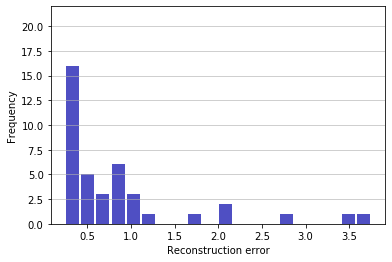

In [27]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=plot_diff_proposed, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
# plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=22)
plt.savefig('./plots/error_histo_proposed_t600.png',dpi=300, bbox_inches = "tight")
# plt.savefig('./plots/error_histo_proposed.eps', format='eps',dpi=300, bbox_inches = "tight")

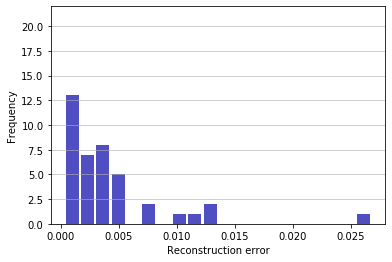

In [37]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=plot_diff_random, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
# plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=22)
plt.savefig('./plots/error_histo_random_t600.png',dpi=300, bbox_inches = "tight")
# plt.savefig('./plots/error_histo_random.eps', format='eps',dpi=300, bbox_inches = "tight")